In [3]:
# CÉLULA 1 - Instalar e importar
!pip install -q tensorflow tensorflow-datasets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os, zipfile, pathlib
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [4]:
# CÉLULA 2 - Baixar dataset cats_vs_dogs (exemplo)
URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_path = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=False)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall('/content/')

base_dir = '/content/cats_and_dogs_filtered'
print("Diretórios em base_dir:", os.listdir(base_dir))


68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Diretórios em base_dir: ['train', 'vectorize.py', 'validation']


In [5]:
# CÉLULA 3 - Criar datasets (train/val)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

print("Classes:", train_ds.class_names)

# otimização de performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Classes: ['cats', 'dogs']


In [6]:
# CÉLULA 2 - Baixar e extrair o conjunto de dados
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
0


In [7]:
# CÉLULA 4 - Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [8]:
# CÉLULA 5 - Construção do modelo com MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # fase inicial: base congelada

inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # saída binária
model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# CÉLULA 6 - Callbacks e treino inicial
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,   # aqui você pode reduzir para 3-5 se quiser testar
    callbacks=callbacks
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5251 - loss: 0.8060

63/63 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.5259 - loss: 0.8051 - val_accuracy: 0.7450 - val_loss: 0.5403 - learning_rate: 1.0000e-04
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7237 - loss: 0.5640

63/63 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.7243 - loss: 0.5633 - val_accuracy: 0.9160 - val_loss: 0.3826 - learning_rate: 1.0000e-04
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8436 - loss: 0.4249

63/63 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.8437 - loss: 0.4246 - val_accuracy: 0.9530 - val_loss: 0.2890 - learning_rate: 1.0000e-04
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8882 - loss: 0.3384

63/63 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.8884 - loss: 0.3381 - val_accuracy: 0.9650 - val_loss: 0.2305 - learning_rate: 1.0000e-04
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9151 - loss: 0.2792

63/63 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9153 - loss: 0.2790 - val_accuracy: 0.9730 - val_loss: 0.1930 - learning_rate: 1.0000e-04
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9316 - loss: 0.2430

63/63 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9316 - loss: 0.2429 - val_accuracy: 0.9730 - val_loss: 0.1649 - learning_rate: 1.0000e-04
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9393 - loss: 0.2068

63/63 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.9394 - loss: 0.2066 - val_accuracy: 0.9750 - val_loss: 0.1454 - learning_rate: 1.0000e-04
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9426 - loss: 0.1928

63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9426 - loss: 0.1927 - val_accuracy: 0.9780 - val_loss: 0.1292 - learning_rate: 1.0000e-04
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9558 - loss: 0.1733

63/63 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9558 - loss: 0.1732 - val_accuracy: 0.9780 - val_loss: 0.1175 - learning_rate: 1.0000e-04
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9521 - loss: 0.1630

63/63 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.9522 - loss: 0.1629 - val_accuracy: 0.9820 - val_loss: 0.1071 - learning_rate: 1.0000e-04


In [ ]:
# CÉLULA 7 - Fine-tuning (descongelar algumas camadas)
base_model.trainable = True
# descongela apenas as últimas 30 camadas (exemplo)
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # LR menor
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # pode ajustar
    callbacks=callbacks
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8785 - loss: 0.3138

63/63 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.8790 - loss: 0.3130 - val_accuracy: 0.9840 - val_loss: 0.0635 - learning_rate: 1.0000e-05
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9410 - loss: 0.1704

63/63 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.9411 - loss: 0.1702 - val_accuracy: 0.9860 - val_loss: 0.0484 - learning_rate: 1.0000e-05
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9615 - loss: 0.1259

63/63 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.9615 - loss: 0.1259 - val_accuracy: 0.9870 - val_loss: 0.0394 - learning_rate: 1.0000e-05
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9608 - loss: 0.1064

63/63 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9609 - loss: 0.1063 - val_accuracy: 0.9860 - val_loss: 0.0344 - learning_rate: 1.0000e-05
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9712 - loss: 0.0866

63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9713 - loss: 0.0865 - val_accuracy: 0.9870 - val_loss: 0.0316 - learning_rate: 1.0000e-05
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9724 - loss: 0.0821

63/63 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.9724 - loss: 0.0820 - val_accuracy: 0.9860 - val_loss: 0.0301 - learning_rate: 1.0000e-05
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9802 - loss: 0.0676

63/63 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9802 - loss: 0.0676 - val_accuracy: 0.9880 - val_loss: 0.0293 - learning_rate: 1.0000e-05
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9829 - loss: 0.0577

63/63 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.9829 - loss: 0.0577 - val_accuracy: 0.9890 - val_loss: 0.0282 - learning_rate: 1.0000e-05
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9786 - loss: 0.0567

63/63 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.9786 - loss: 0.0567 - val_accuracy: 0.9880 - val_loss: 0.0274 - learning_rate: 1.0000e-05
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9883 - loss: 0.0455 - val_accuracy: 0.9880 - val_loss: 0.0275 - learning_rate: 1.0000e-05


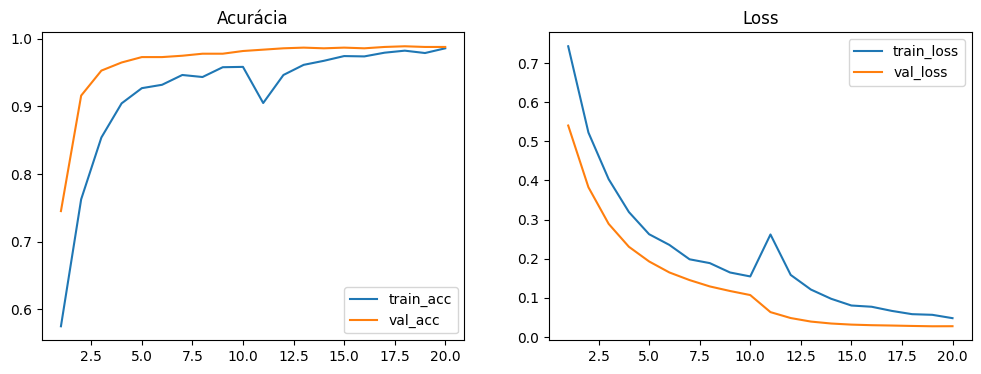

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=final_model.

In [ ]:
# CÉLULA 8 - Plots, salvar imagens e salvar modelo
import os
os.makedirs('images', exist_ok=True)
import matplotlib.pyplot as plt

def plot_history(h1, h2=None):
    acc = h1.history.get('accuracy', [])
    val_acc = h1.history.get('val_accuracy', [])
    loss = h1.history.get('loss', [])
    val_loss = h1.history.get('val_loss', [])
    if h2:
        acc += h2.history.get('accuracy', [])
        val_acc += h2.history.get('val_accuracy', [])
        loss += h2.history.get('loss', [])
        val_loss += h2.history.get('val_loss', [])
    epochs = range(1, len(acc)+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='train_acc'); plt.plot(epochs, val_acc, label='val_acc'); plt.legend(); plt.title('Acurácia')
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='train_loss'); plt.plot(epochs, val_loss, label='val_loss'); plt.legend(); plt.title('Loss')
    plt.savefig('images/train_history.png')
    plt.show()

plot_history(history, history_fine if 'history_fine' in globals() else None)

# salvar modelo final e comprimir para download
model.save('final_model')
!zip -r final_model.zip final_model

# salvar requirements
!pip freeze > requirements.txt

# salvar 4 exemplos de previsões da validação
for images_batch, labels_batch in val_ds.take(1):
    preds = model.predict(images_batch)
    for i in range(min(4, images_batch.shape[0])):
        plt.figure(figsize=(3,3))
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(f"Label: {int(labels_batch[i].numpy())} Pred: {float(preds[i][0]):.3f}")
        plt.axis('off')
        plt.savefig(f'images/sample_{i}.png')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')